# A billion stars in the Jupyter Notebook
## PyData meetup - Paris  2017

In [1]:
1+1

2

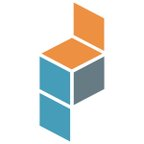

In [2]:
import IPython.display
IPython.display.Image(filename="logo.png")

$ E \approx mc^2$

In [3]:
import vaex
import numpy as np
import matplotlib.pylab as plt

plt.style.use('bigfont')
%matplotlib inline

# Step 0: reading in data
vaex reads 'anything':
 * `ds = vaex.open('super_fast.hdf5')`
 * `ds = vaex.open('gadget_is_fine.hdf5')`
 * `ds = vaex.from_pandas(df)`
 * `ds = vaex.from_astropy_table(table)`
 * `ds = vaex.from_ascii('takes_hours.asc')`
 * `ds = vaex.from_csv('this_may_be_slow.csv')`
 * `ds = vaex.from_arrays(x=x, y=y)`

In [5]:
%%time
ds = vaex.open("/Users/maartenbreddels/vaex/data/nytaxi/nyc_taxi2015.hdf5")
!ls -lh /Users/maartenbreddels/vaex/data/nytaxi/nyc_taxi2015.hdf5

-rw-r--r--@ 1 maartenbreddels  staff    23G Mar 29 07:32 /Users/maartenbreddels/vaex/data/nytaxi/nyc_taxi2015.hdf5
CPU times: user 15.7 ms, sys: 12.5 ms, total: 28.2 ms
Wall time: 156 ms


In [6]:
ds

column,type,unit,description,expression
VendorID,int64,,,
dropoff_dayofweek,float64,,,
dropoff_hour,float64,,,
dropoff_latitude,float64,,,
dropoff_longitude,float64,,,
extra,float64,,,
fare_amount,float64,,,
improvement_surcharge,float64,,,
mta_tax,float64,,,
passenger_count,int64,,,


## 0 dimensional

In [7]:
ds.count()

146112989.0

In [8]:
%%time
ds.count("pickup_latitude")

CPU times: user 588 ms, sys: 389 ms, total: 977 ms
Wall time: 285 ms


143807893.0

In [9]:
ds.mean("pickup_latitude")

40.750600575372054

## 1 dimensional

In [10]:
ds.count(binby="pickup_latitude", limits=[40.5, 41])

array([  4.10000000e+01,   3.40000000e+01,   3.60000000e+01,
         4.70000000e+01,   1.03000000e+02,   1.66000000e+02,
         7.20000000e+01,   8.30000000e+01,   6.80000000e+01,
         9.70000000e+01,   9.30000000e+01,   5.90000000e+01,
         1.20000000e+02,   8.40000000e+01,   1.09000000e+02,
         1.65000000e+02,   1.27000000e+02,   1.73000000e+02,
         2.53000000e+02,   9.70000000e+02,   7.93000000e+02,
         1.63700000e+03,   1.23500000e+03,   1.05600000e+03,
         1.53800000e+03,   1.82200000e+03,   1.82600000e+03,
         2.30300000e+03,   2.42300000e+03,   3.79700000e+03,
         3.82400000e+03,   4.67500000e+03,   3.98900000e+03,
         6.77900000e+03,   8.79900000e+03,   1.11450000e+04,
         7.02189000e+05,   2.05215400e+06,   3.30456000e+05,
         3.20690000e+04,   3.91210000e+04,   4.22370000e+04,
         4.75130000e+04,   7.15520000e+04,   9.84480000e+04,
         1.78168000e+05,   2.20416000e+05,   2.37613000e+05,
         2.79931000e+05,

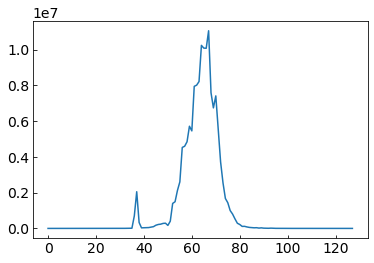

In [11]:
plt.plot(_)

## 2 dimensional

In [13]:
counts2d = ds.count(binby=["pickup_longitude", "pickup_latitude"], shape=128)
print(counts2d.shape)

(128, 128)


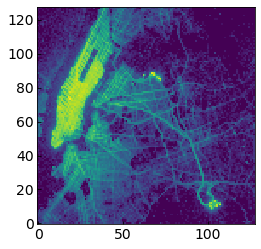

In [14]:
plt.imshow(np.log10(counts2d+1).T, origin='lower')

In [15]:
limits = ds.limits(["pickup_longitude", "pickup_latitude"], "98%")
print(limits)

[array([-74.03799976, -73.774866  ]), array([ 40.6379567 ,  40.81379327])]


CPU times: user 2.78 s, sys: 64.3 ms, total: 2.84 s
Wall time: 996 ms


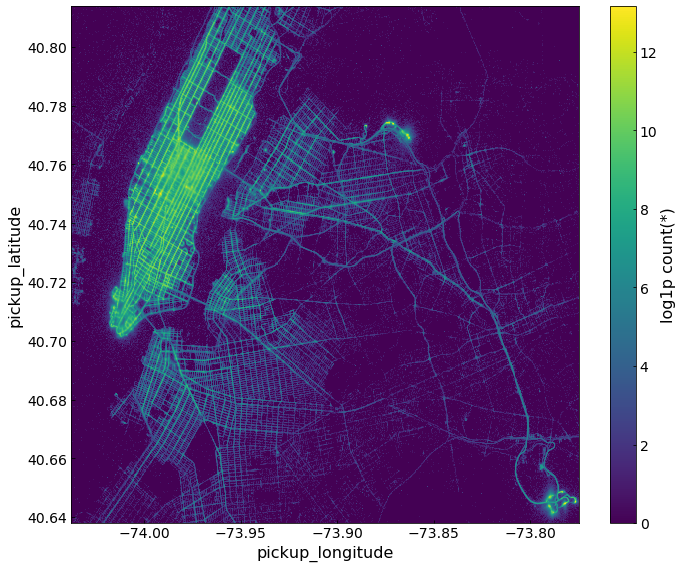

In [16]:
%%time
ds.plot("pickup_longitude", "pickup_latitude", f="log1p",
        limits=limits, figsize=(10,8), shape=512, colormap="viridis")

In [ ]:
# %%timeit
# counts2d = ds.count(binby=["pickup_longitude", "pickup_latitude"], shape=128, limits=limits)#, limits=[[-90, 90], [-180, 180]])

## Where to pick up customers?

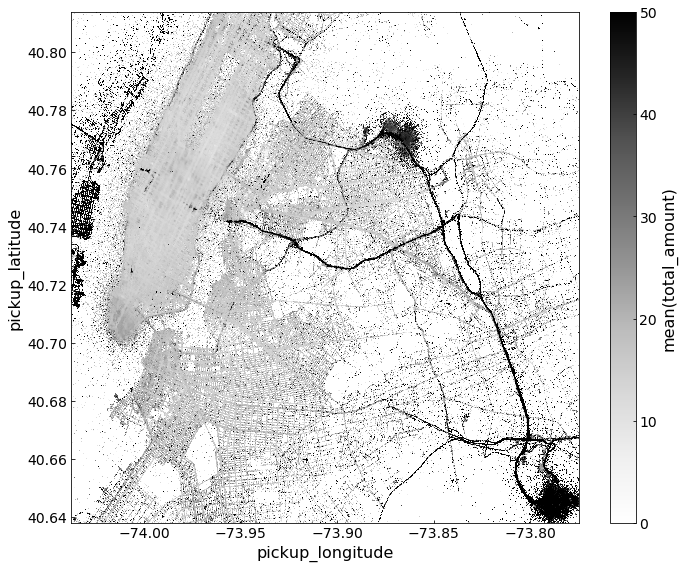

In [17]:
ds.plot("pickup_longitude", "pickup_latitude", what="mean(total_amount)",
        vmin=0, vmax=50, shape=512, figsize=(10,8), limits=limits, colormap="Greys")

In [18]:
ds.minmax("trip_distance")

array([ -4.08401244e+07,   1.98623014e+08])

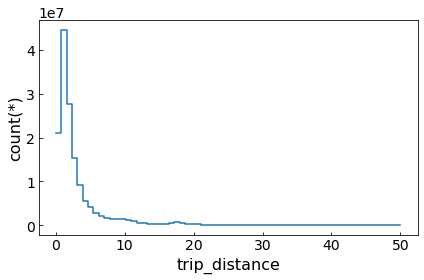

In [19]:
ds.plot1d("trip_distance", limits=[0, 50])

In [20]:
ds.select("(trip_distance > 0) & (trip_distance < 40)")

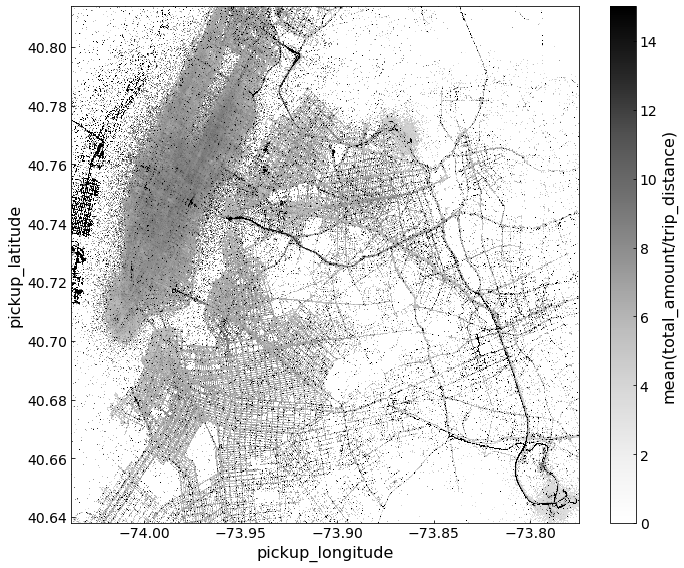

In [21]:
ds.plot("pickup_longitude", "pickup_latitude", what="mean(total_amount/trip_distance)",
       selection=True, vmin=0, vmax=15,
       shape=512, figsize=(10,8), limits=limits, colormap="Greys")

## Custom functions / virtual functions

In [22]:
# do not do
#ratio = ds.data.total_amount/ds.data.trip_distance
print(len(ds.data.total_amount) * 8 / 1024**3, "GB")

1.0886266008019447 GB


In [23]:
ds.set_active_fraction(0.5)
ds.select("(trip_distance > 0) & (trip_distance < 40)")

In [24]:
ds.add_virtual_column("ratio", "total_amount/trip_distance")

In [25]:
ds.mean("ratio", selection=True)

8.1787729280908295

In [26]:
def my_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 6400

In [27]:
# NOTE: this part will only work with master from github, or the next release (after 1.0.0b6)
ds.add_virtual_column("my_distance", my_distance,
                        "pickup_longitude", "pickup_latitude",
                        "dropoff_longitude", "dropoff_latitude")


In [29]:
%%time
ds.mean('my_distance', selection=True)

CPU times: user 13.5 s, sys: 3.62 s, total: 17.2 s
Wall time: 5.51 s


2.8716130889609977

In [30]:
%load_ext pythran.magic

WARNING  Pythran support disabled for module: omp


In [31]:
%%pythran
import numpy as np
#pythran export my_distance_pythran(float[], float[], float[], float[])
def my_distance_pythran(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 6400

INFO     customize UnixCCompiler
INFO:MainThread:pythran:customize UnixCCompiler


running build_ext
running build_src
build_src
building extension "pythranized_ab186a9c1a2a6a21326feb4fd23f478b" sources
build_src: building npy-pkg config files
new_compiler returns <class 'distutils.unixccompiler.UnixCCompiler'>


INFO     customize UnixCCompiler
INFO:MainThread:pythran:customize UnixCCompiler


customize UnixCCompiler using build_ext
********************************************************************************
<class 'distutils.unixccompiler.UnixCCompiler'>
compiler      = ['/usr/bin/clang', '-Wno-unused-result', '-Wsign-compare', '-Wunreachable-code', '-DNDEBUG', '-g', '-fwrapv', '-O3', '-Wall', '-Wstrict-prototypes', '-I/Users/maartenbreddels/anaconda3/include', '-arch', 'x86_64']
linker_so     = ['/usr/bin/clang', '-bundle', '-undefined', 'dynamic_lookup', '-L/Users/maartenbreddels/anaconda3/lib', '-arch', 'x86_64']
compiler_cxx  = ['/usr/bin/clang++']
linker_exe    = ['/usr/bin/clang']
preprocessor  = ['/usr/bin/clang', '-E']
ranlib        = ['ranlib']
compiler_so   = ['/usr/bin/clang', '-Wno-unused-result', '-Wsign-compare', '-Wunreachable-code', '-DNDEBUG', '-g', '-fwrapv', '-O3', '-Wall', '-Wstrict-prototypes', '-I/Users/maartenbreddels/anaconda3/include', '-arch', 'x86_64']
archiver      = ['ar', 'rc']
libraries     = []
library_dirs  = ['/Users/maartenbreddels/ana

INFO     customize UnixCCompiler
INFO:MainThread:pythran:customize UnixCCompiler


customize UnixCCompiler using build_ext
********************************************************************************
<class 'distutils.unixccompiler.UnixCCompiler'>
compiler      = ['/usr/bin/clang', '-Wno-unused-result', '-Wsign-compare', '-Wunreachable-code', '-DNDEBUG', '-g', '-fwrapv', '-O3', '-Wall', '-Wstrict-prototypes', '-I/Users/maartenbreddels/anaconda3/include', '-arch', 'x86_64']
linker_so     = ['/usr/bin/clang', '-bundle', '-undefined', 'dynamic_lookup', '-L/Users/maartenbreddels/anaconda3/lib', '-arch', 'x86_64']
compiler_cxx  = ['/usr/bin/clang++']
linker_exe    = ['/usr/bin/clang']
preprocessor  = ['/usr/bin/clang', '-E']
ranlib        = ['ranlib']
compiler_so   = ['/usr/bin/clang', '-Wno-unused-result', '-Wsign-compare', '-Wunreachable-code', '-DNDEBUG', '-g', '-fwrapv', '-O3', '-Wall', '-I/Users/maartenbreddels/anaconda3/include', '-arch', 'x86_64']
archiver      = ['ar', 'rc']
libraries     = []
library_dirs  = ['/Users/maartenbreddels/anaconda3/lib']
include_di

INFO     Generated module: pythranized_ab186a9c1a2a6a21326feb4fd23f478b
INFO:MainThread:pythran:Generated module: pythranized_ab186a9c1a2a6a21326feb4fd23f478b
INFO     Output: /Users/maartenbreddels/Dropbox/werk/trips/pydata-paris-meetup-2017/pythranized_ab186a9c1a2a6a21326feb4fd23f478b.so
INFO:MainThread:pythran:Output: /Users/maartenbreddels/Dropbox/werk/trips/pydata-paris-meetup-2017/pythranized_ab186a9c1a2a6a21326feb4fd23f478b.so


In [32]:
# NOTE: this part will only work with master from github, or the next release (after 1.0.0b6)
ds.add_virtual_column("my_distance_pythran", my_distance_pythran,
                        "pickup_longitude", "pickup_latitude",
                        "dropoff_longitude", "dropoff_latitude")

In [33]:
%%time
ds.mean('my_distance_pythran', selection=True)

CPU times: user 11.5 s, sys: 490 ms, total: 12 s
Wall time: 3.32 s


2.8716130889610092

In [34]:
ds.add_virtual_column("bonus_multiplier", "(trip_distance*1.6/my_distance_pythran)")

In [35]:
ds.select('pickup_longitude != dropoff_longitude', mode="and")

In [36]:
ds.mean("bonus_multiplier", selection=True)

3.76292973146482

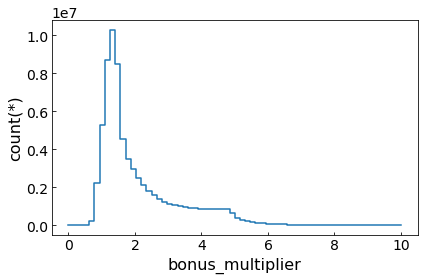

In [37]:
ds.plot1d("bonus_multiplier", selection=True, limits=[0, 10])

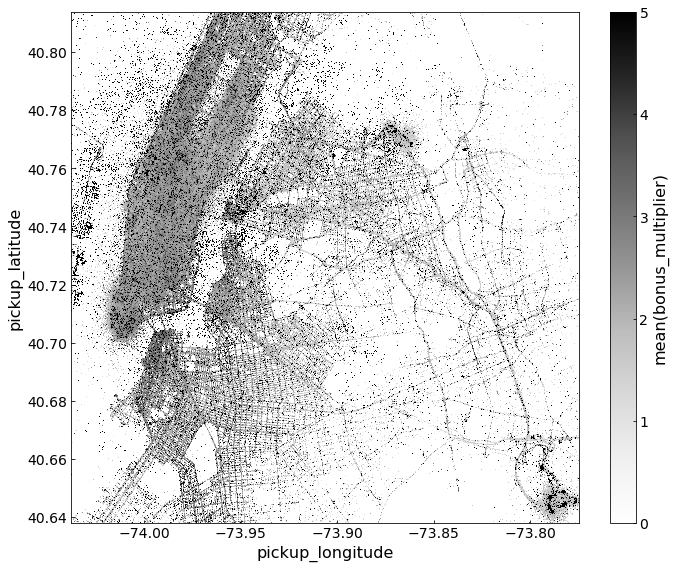

In [38]:
ds.plot("pickup_longitude", "pickup_latitude", what="mean(bonus_multiplier)",
       selection=True, vmin=0, vmax=5,
       shape=512, figsize=(10,8), limits=limits, colormap="Greys")

## A Billion stars in the notebook

In [39]:
gaia = vaex.open("ws://gaia:9000/gaia-dr1")

In [40]:
len(gaia)/1e9

1.142679769

CPU times: user 1.66 s, sys: 295 ms, total: 1.95 s
Wall time: 5.04 s


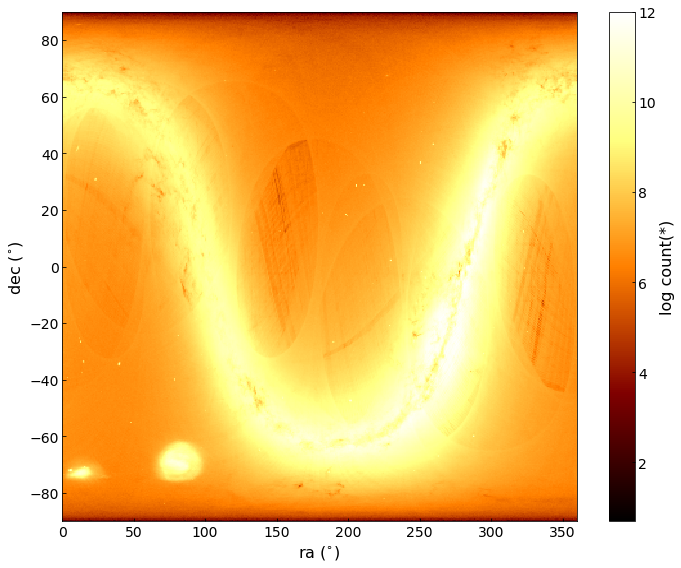

In [41]:
%%time
ra_dec_limits = [[0, 360], [-90, 90]]
gaia.plot("ra", "dec", limits=ra_dec_limits, f="log", figsize=(10,8), shape=400)
plt.savefig('gaia-backup.png')

In [ ]:
import PIL.Image

In [ ]:
PIL.Image.open('gaia-backup.png')